In [150]:
import datetime
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
def peek(df):
    display(df.iloc[0:3, :])
    print(len(df))

In [3]:
def repair_dates(df):
    df['date_range_start'] = pd.to_datetime(df['date_range_start'], utc=True)
    df['date_range_start'] = df['date_range_start'].dt.tz_convert('US/Eastern')

In [74]:
def smoothen(df, columns=[], N=6):
    """Returns a copy of the given dataframe with a rolling-day average of the
    given size applied to the given columns."""
    rolling_groupby = df.copy().reset_index(level=1).groupby(by=['cluster'])
    rolling_df = rolling_groupby[columns].rolling(N + 1, center=True).mean()
    rolling_df = rolling_df.reset_index()
    rolling_df = rolling_df.sort_values(by=['date_range_start', 'cluster'])
    rolling_df = rolling_df.set_index(['date_range_start', 'cluster'])
    return rolling_df

def smoothen_within(df, columns=[], by=None, N=6):
    """Returns a copy of the given dataframe with a rolling-day average of the
    given size applied to the given columns within each attribute class
    determined by the given "by" attribute."""
    attr_classes = set(df[by])
    rolling_dfs = []
    for attr_class in attr_classes:
        attr_class_df = df[df[by] == attr_class]
        rolling_dfs.append(smoothen(attr_class_df, columns, N=N))
    rolling_df = pd.concat(rolling_dfs)
    rolling_df = rolling_df.sort_values(by=['date_range_start', by])
    return rolling_df

In [5]:
home_weekly_df = pd.read_csv(f'./exports/home_weekly.csv')
repair_dates(home_weekly_df)
home_weekly_df = home_weekly_df[home_weekly_df['date_range_start'].dt.year.isin([2019, 2020])]
home_weekly_df = home_weekly_df.rename(columns={'home_cbg': 'cbg'})
peek(home_weekly_df)

,placekey,date_range_start,cbg,visitor_count,estimated_visitor_count,pct_visitor_count,pct_estimated_visitor_count,cdi
95,22t-222@627-s7m-rtv,2019-01-07 00:00:00-05:00,360050001000,4,0.000000,0.333333,0.000000,0.000000
96,22t-222@627-s7m-rtv,2019-01-07 00:00:00-05:00,360470206001,4,9.790000,0.021739,0.021739,2.772665
97,22t-222@627-s7m-rtv,2019-01-07 00:00:00-05:00,360470435003,4,8.605042,0.016129,0.016129,2.437068


26675352


In [6]:
poi_df = pd.read_csv(f'./exports/poi_health_recategorized.csv')
categories = list(set(poi_df['category']))
peek(poi_df)

,placekey,cbg,naics_code,category,sub_category,location_name,area_square_feet,latitude,longitude
0,226-222@627-s4n-pqf,360610158022,311811,Snacks and Bakeries,Retail Bakeries,Unna Bakery,NaN,40.787027,-73.950435
1,225-225@627-s99-9xq,360810849002,311811,Snacks and Bakeries,Retail Bakeries,Fay Da Bakery,24759.0,40.756244,-73.829009
2,225-225@627-vsw-7nq,360850146071,311811,Snacks and Bakeries,Retail Bakeries,Amici Bakery,16166.0,40.559894,-74.166016


36467


In [251]:
def apply_cluster_by_income(df):
    cdf = df.copy()
    median_income = 63998
    
    pct10 = np.percentile(cdf['income'].dropna(), 10)
    pct50 = np.percentile(cdf['income'].dropna(), 50)
    pct90 = np.percentile(cdf['income'].dropna(), 90)
    print(pct10, pct50, pct90)
    
    cdf['cluster'] = None
    cdf.loc[(cdf['income'] <= pct10), 'cluster'] = 0
    cdf.loc[(cdf['income'] > pct10) & (cdf['income'] <= pct50), 'cluster'] = 1
    cdf.loc[(cdf['income'] > pct50) & (cdf['income'] <= pct90), 'cluster'] = 2
    cdf.loc[(cdf['income'] > pct90), 'cluster'] = 3

In [279]:
cbg_df = pd.read_csv('./data/cbg_attr_and_cluster_1021.csv')
cbg_df = cbg_df.rename(columns={
    'census_block_group': 'cbg',
    'Median Household Income': 'income',
    'Total Population': 'population',
    'Percent Households with one or more people under 18 years': 'pct_children',
    'Percent Household received Food Stamps/SNAP': 'pct_snap',
    'Percent Households Income in the past 12 months below poverty level': 'pct_poverty',
})

In [253]:
apply_cluster_by_income(cbg_df)
cbg_cluster_df = cbg_df[['cbg', 'cluster']]
home_cluster_df = home_weekly_df.merge(cbg_df[['cbg', ]], on=['cbg'], how='inner')

30140.0 68164.0 128646.0


In [284]:
def get_total_df(cluster_df):
    total_df = cluster_df.groupby(by=['date_range_start', 'cluster']).agg(
        {
            'estimated_visitor_count': 'sum'
        }).reset_index()
    total_df = total_df.rename(
        columns={'estimated_visitor_count': 'total_estimated_visitor_count'})
    total_df = total_df.sort_values(by=['date_range_start', 'cluster'])
    peek(total_df)
    return total_df

In [390]:
def get_weekly_df(cluster_df, total_df, poi_df=poi_df):
    weekly_df = cluster_df.merge(poi_df[['placekey', 'category']],
                                    on='placekey',
                                    how='inner')
    weekly_df = weekly_df.groupby(by=['date_range_start', 'category', 'cluster']).agg({
        'estimated_visitor_count': 'sum'
    }).reset_index()
    weekly_df = weekly_df.merge(total_df,
                            on=['date_range_start', 'cluster'],
                            how='inner')
    weekly_df = weekly_df.sort_values(by=['date_range_start', 'category', 'cluster'])
    weekly_df['percent'] = weekly_df['estimated_visitor_count'] / weekly_df[
        'total_estimated_visitor_count']
    peek(weekly_df)
    return weekly_df

In [288]:
def get_percent_df(weekly_df):
    percent_df = weekly_df.pivot(index=['date_range_start', 'cluster'], columns=['category'], values=['percent'])
    percent_df = smoothen(percent_df, percent_df.columns)
    percent_df.columns = percent_df.columns.get_level_values(1)
    peek(percent_df)
    return percent_df

In [289]:
total_df = get_total_df(home_cluster_df)
weekly_df = get_weekly_df(home_cluster_df, total_df)
percent_df = get_percent_df(weekly_df)


,date_range_start,cluster,total_estimated_visitor_count
0,2019-01-07 00:00:00-05:00,0,2.715550e+05
1,2019-01-07 00:00:00-05:00,1,1.171878e+06
2,2019-01-07 00:00:00-05:00,2,1.103942e+06


408


,date_range_start,category,cluster,estimated_visitor_count,total_estimated_visitor_count,percent
0,2019-01-07 00:00:00-05:00,"Beer, Wine, and Liquor Stores",0,3605.558921,2.715550e+05,0.013277
14,2019-01-07 00:00:00-05:00,"Beer, Wine, and Liquor Stores",1,13839.587168,1.171878e+06,0.011810
28,2019-01-07 00:00:00-05:00,"Beer, Wine, and Liquor Stores",2,11760.656548,1.103942e+06,0.010653


5712


category                           Beer, Wine, and Liquor Stores  \
date_range_start          cluster                                  
2019-01-07 00:00:00-05:00 0                                  NaN   
                          1                                  NaN   
                          2                                  NaN   

category                           Big Box Grocers  \
date_range_start          cluster                    
2019-01-07 00:00:00-05:00 0                    NaN   
                          1                    NaN   
                          2                    NaN   

category                           Delis and Convenience Stores  \
date_range_start          cluster                                 
2019-01-07 00:00:00-05:00 0                                 NaN   
                          1                                 NaN   
                          2                                 NaN   

category                           Drinking Places  Fast-Food Restaurants  \
date_range_start          cluster                                           
2019-01-07 00:00:00-05:00 0                    NaN                    NaN   
                          1                    NaN                    NaN   
                          2                    NaN                    NaN   

category                           Food Services  Full-Service Restaurants  \
date_range_start          cluster                                            
2019-01-07 00:00:00-05:00 0                  NaN                       NaN   
                          1                  NaN                       NaN   
                          2                  NaN                       NaN   

category                           General Merchandise Stores  \
date_range_start          cluster                               
2019-01-07 00:00:00-05:00 0                               NaN   
                          1                               NaN   
                          2                               NaN   

category                           Limited-Service Restaurants  \
date_range_start          cluster                                
2019-01-07 00:00:00-05:00 0                                NaN   
                          1                                NaN   
                          2                                NaN   

category                           Pharmacies and Drug Stores  \
date_range_start          cluster                               
2019-01-07 00:00:00-05:00 0                               NaN   
                          1                               NaN   
                          2                               NaN   

category                           Snacks and Bakeries  Specialty Food Stores  \
date_range_start          cluster                                               
2019-01-07 00:00:00-05:00 0                        NaN                    NaN   
                          1                        NaN                    NaN   
                          2                        NaN                    NaN   

category                           Supermarkets  Tobacco Stores  
date_range_start          cluster                                
2019-01-07 00:00:00-05:00 0                 NaN             NaN  
                          1                 NaN             NaN  
                          2                 NaN             NaN

408


In [290]:
# Verify that percentages sum to 100%.
check_df = weekly_df.groupby(by=['date_range_start', 'cluster']).agg({
    'estimated_visitor_count': 'sum',
    'total_estimated_visitor_count': 'first',
    'percent': 'sum',
})
TOLERANCE = 0.001
print('Weeks not summing to 100%:')
display(len(check_df[check_df['percent'] < 1 - TOLERANCE]))
display(len(check_df[check_df['percent'] > 1 + TOLERANCE]))
peek(check_df)

Weeks not summing to 100%:


0

0

estimated_visitor_count  \
date_range_start          cluster                            
2019-01-07 00:00:00-05:00 0                   2.715550e+05   
                          1                   1.171878e+06   
                          2                   1.103942e+06   

                                   total_estimated_visitor_count  percent  
date_range_start          cluster                                          
2019-01-07 00:00:00-05:00 0                         2.715550e+05      1.0  
                          1                         1.171878e+06      1.0  
                          2                         1.103942e+06      1.0

408


In [291]:
def plot_stack(df, n_clusters=1, columns=[], labels=[], title=''):
    fig, ax = plt.subplots(2, n_clusters, figsize=(24, 8))
    
    for i in range(1, n_clusters):
        ax[0, i].sharey(ax[0, 0])
        ax[1, i].sharey(ax[1, 0])

    cmap = plt.cm.get_cmap('tab20')
    colors = [cmap(i / 20) for i in range(0, 20)]

    rdf = df.reset_index(level=1)
    for i in range(n_clusters):
        cdf = rdf[rdf['cluster'] == i].drop(columns=['cluster'])[columns]
        ax[0, i].stackplot(cdf.index, cdf.transpose(), labels=[c for c in columns], colors=colors, alpha=0.8)
        ax[0, i].axvline(datetime.datetime(2020, 3, 20), linestyle='--', color='#000')

        for j, label in enumerate(columns):
            ax[1, i].plot(cdf.index, cdf.iloc[:, j], color=colors[j], label=label)
        ax[1, i].axvline(datetime.datetime(2020, 3, 20), linestyle='--', color='#000')
        
        if i == 0:
            ax[0, i].legend(loc='lower left')
            ax[1, i].legend(loc='lower left')
            
    
        ax[0, i].yaxis.set_tick_params(labelleft=True)
        ax[1, i].yaxis.set_tick_params(labelleft=True)
        ax[0, i].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        ax[1, i].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        
    for i, label in enumerate(labels):
        ax[0, i].set_title(label)
            
    plt.suptitle(title, fontsize=18)
    plt.tight_layout()
    plt.show()

In [292]:
labels_income = [
    'Bottom 10% CBGs by Income',
    'Bottom 10-50% CBGs by Income',
    'Top 50%-10% CBGs by Income',
    'Top 10% CBGs by Income',
]

In [293]:
pdf = percent_df.reset_index()
pdf
#len(pdf[pdf['cluster'] == 3])

category,date_range_start,cluster,"Beer, Wine, and Liquor Stores",Big Box Grocers,Delis and Convenience Stores,Drinking Places,Fast-Food Restaurants,Food Services,Full-Service Restaurants,General Merchandise Stores,Limited-Service Restaurants,Pharmacies and Drug Stores,Snacks and Bakeries,Specialty Food Stores,Supermarkets,Tobacco Stores
0,2019-01-07 00:00:00-05:00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-07 00:00:00-05:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-07 00:00:00-05:00,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-07 00:00:00-05:00,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-14 00:00:00-05:00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,2020-12-21 00:00:00-05:00,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
404,2020-12-28 00:00:00-05:00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
405,2020-12-28 00:00:00-05:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
406,2020-12-28 00:00:00-05:00,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


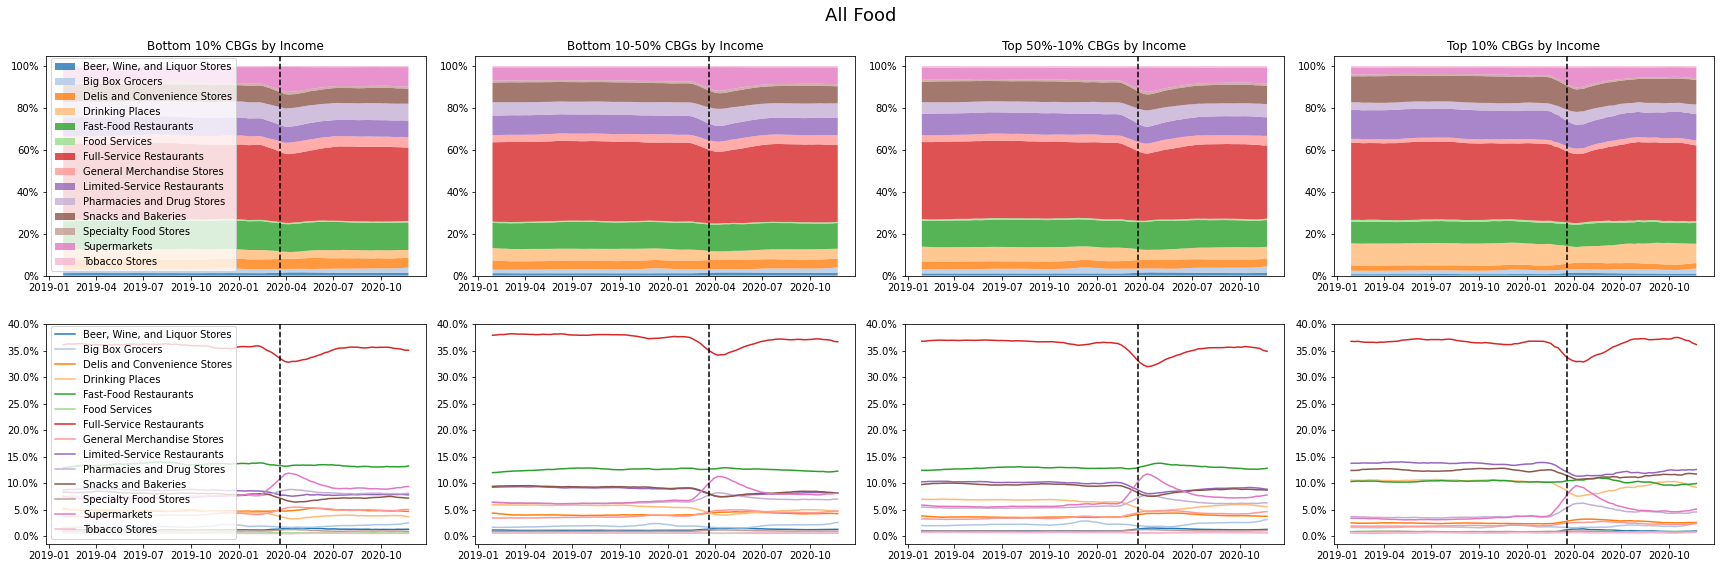

In [294]:
plot_stack(percent_df, n_clusters=4, columns=percent_df.columns, labels=labels_income, title='All Food')

In [300]:
unhealthy_categories = [
    'Delis and Convenience Stores',
    'Fast-Food Restaurants',
]
alcohol_categories = [
    'Beer, Wine, and Liquor Stores',
    'Drinking Places',
]
grocery_categories = [
    'Big Box Grocers',
    'Delis and Convenience Stores',
    'Specialty Food Stores',
    'Supermarkets',
]
prepared_food_categories = [
    'Fast-Food Restaurants',
    'Full-Service Restaurants',
    'Limited-Service Restaurants',
    'Snacks and Bakeries',
]

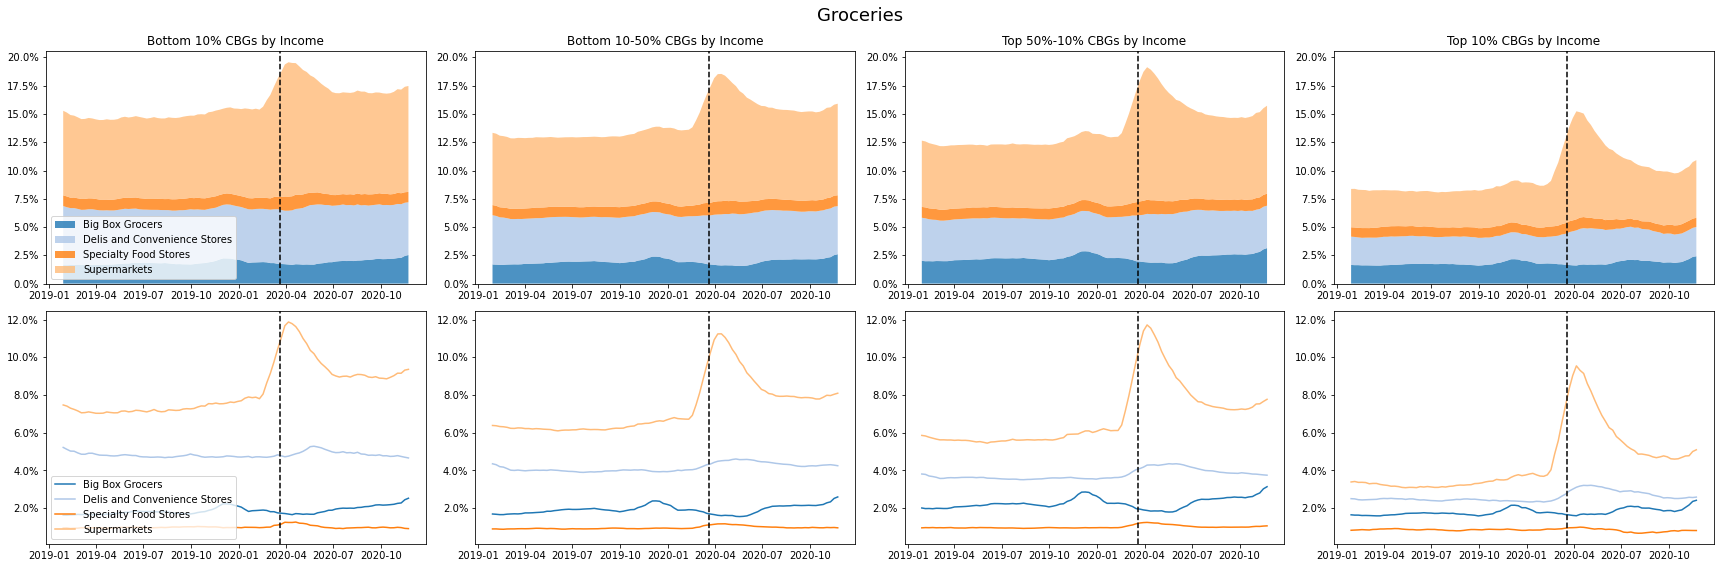

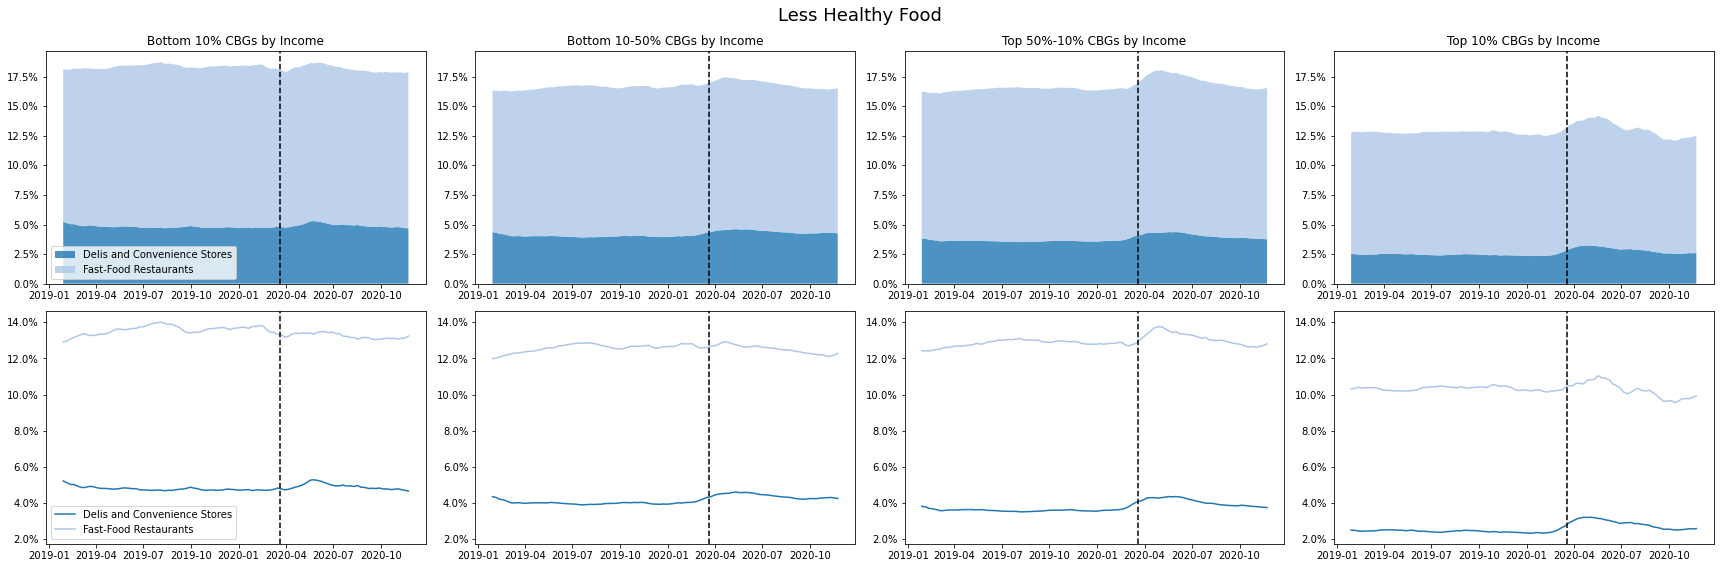

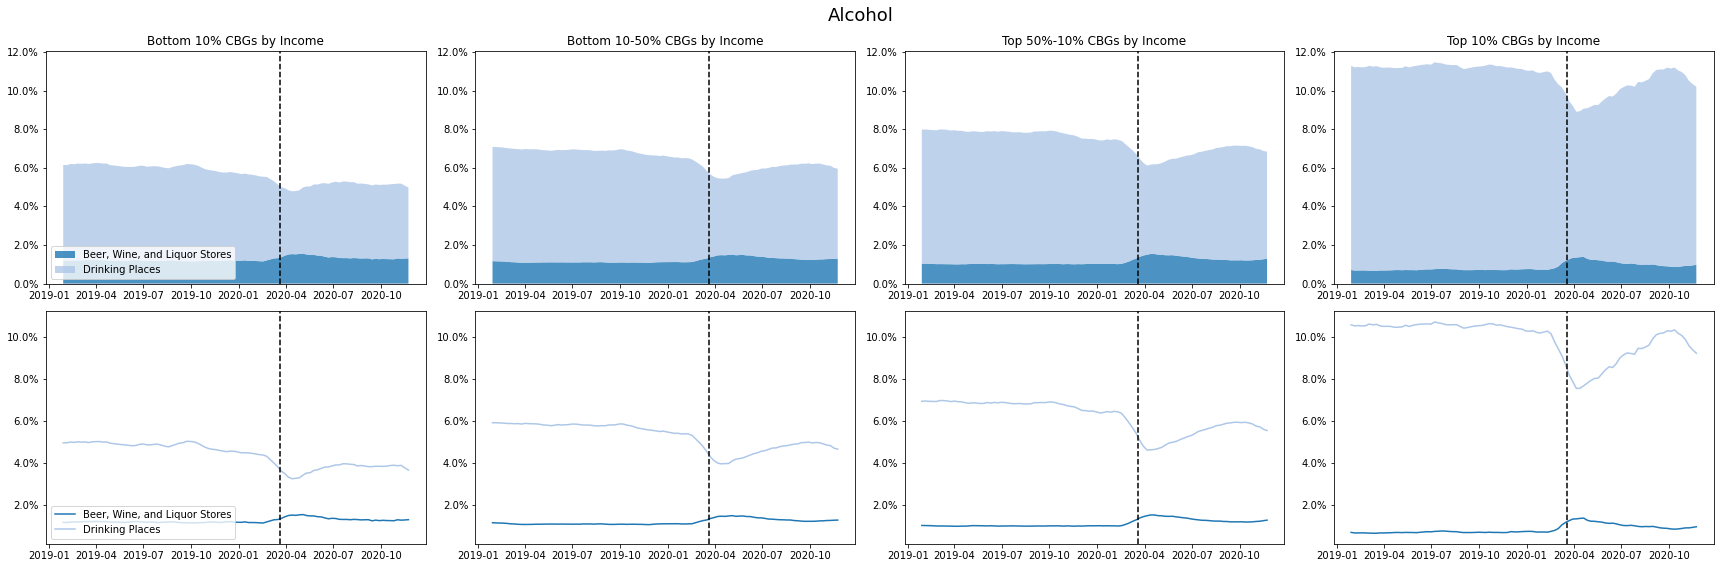

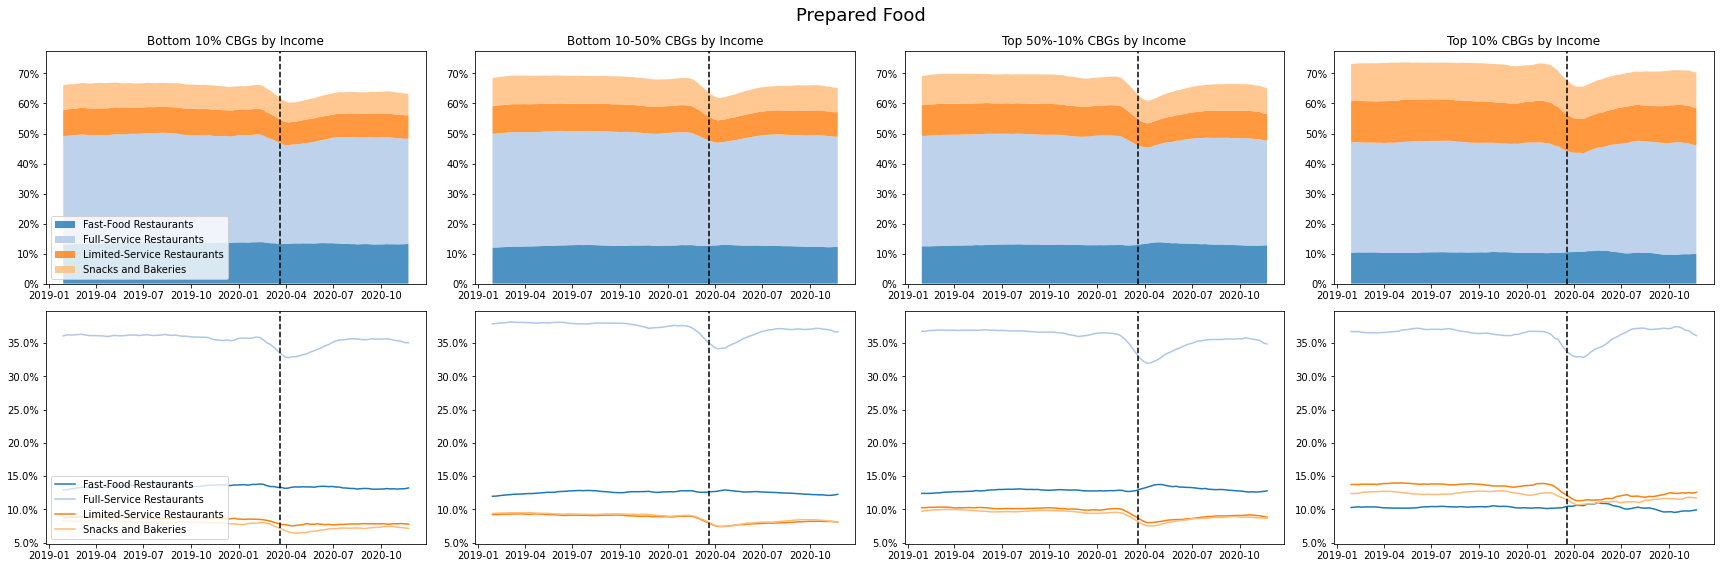

In [301]:
plot_stack(percent_df, n_clusters=4, columns=grocery_categories, labels=labels_income, title='Groceries')
plot_stack(percent_df, n_clusters=4, columns=unhealthy_categories, labels=labels_income, title='Less Healthy Food')
plot_stack(percent_df, n_clusters=4, columns=alcohol_categories, labels=labels_income, title='Alcohol')
plot_stack(percent_df, n_clusters=4, columns=prepared_food_categories, labels=labels_income, title='Prepared Food')

In [374]:
def apply_percentiles_by_income(df):
    cdf = df.copy()
    percents = list(range(5, 105, 5))
    values = [np.percentile(cdf['income'].dropna(), p) for p in percents]
    display(values)
    
    cdf['cluster'] = None
    for i, value in enumerate(values):
        cdf.loc[(cdf['cluster'].isna()) & (cdf['income'] <= value), 'cluster'] = i
    return cdf

In [375]:
cbg_pct_df = apply_percentiles_by_income(cbg_df)
cbg_pct_df = cbg_pct_df[['cbg', 'cluster']]
pct_cluster_df = home_weekly_df.merge(cbg_pct_df, on=['cbg'], how='inner')
pct_total_df = get_total_df(pct_cluster_df)
pct_weekly_df = get_weekly_df(pct_cluster_df, pct_total_df)
pct_percent_df = get_percent_df(pct_weekly_df)

[21441.0,
 30140.0,
 36541.5,
 41786.0,
 46599.0,
 51250.0,
 55306.5,
 59615.0,
 63725.5,
 68164.0,
 72500.0,
 76726.0,
 81686.0,
 86897.0,
 93750.0,
 101694.0,
 111272.5,
 128646.0,
 158452.0,
 250001.0]

,date_range_start,cluster,total_estimated_visitor_count
0,2019-01-07 00:00:00-05:00,0,134127.130010
1,2019-01-07 00:00:00-05:00,1,137427.876920
2,2019-01-07 00:00:00-05:00,2,136954.220221


2040


,date_range_start,category,cluster,estimated_visitor_count,total_estimated_visitor_count,percent
0,2019-01-07 00:00:00-05:00,"Beer, Wine, and Liquor Stores",0,1834.145960,134127.130010,0.013675
14,2019-01-07 00:00:00-05:00,"Beer, Wine, and Liquor Stores",1,1771.412961,137427.876920,0.012890
28,2019-01-07 00:00:00-05:00,"Beer, Wine, and Liquor Stores",2,1655.331815,136954.220221,0.012087


28560


category                           Beer, Wine, and Liquor Stores  \
date_range_start          cluster                                  
2019-01-07 00:00:00-05:00 0                                  NaN   
                          1                                  NaN   
                          2                                  NaN   

category                           Big Box Grocers  \
date_range_start          cluster                    
2019-01-07 00:00:00-05:00 0                    NaN   
                          1                    NaN   
                          2                    NaN   

category                           Delis and Convenience Stores  \
date_range_start          cluster                                 
2019-01-07 00:00:00-05:00 0                                 NaN   
                          1                                 NaN   
                          2                                 NaN   

category                           Drinking Places  Fast-Food Restaurants  \
date_range_start          cluster                                           
2019-01-07 00:00:00-05:00 0                    NaN                    NaN   
                          1                    NaN                    NaN   
                          2                    NaN                    NaN   

category                           Food Services  Full-Service Restaurants  \
date_range_start          cluster                                            
2019-01-07 00:00:00-05:00 0                  NaN                       NaN   
                          1                  NaN                       NaN   
                          2                  NaN                       NaN   

category                           General Merchandise Stores  \
date_range_start          cluster                               
2019-01-07 00:00:00-05:00 0                               NaN   
                          1                               NaN   
                          2                               NaN   

category                           Limited-Service Restaurants  \
date_range_start          cluster                                
2019-01-07 00:00:00-05:00 0                                NaN   
                          1                                NaN   
                          2                                NaN   

category                           Pharmacies and Drug Stores  \
date_range_start          cluster                               
2019-01-07 00:00:00-05:00 0                               NaN   
                          1                               NaN   
                          2                               NaN   

category                           Snacks and Bakeries  Specialty Food Stores  \
date_range_start          cluster                                               
2019-01-07 00:00:00-05:00 0                        NaN                    NaN   
                          1                        NaN                    NaN   
                          2                        NaN                    NaN   

category                           Supermarkets  Tobacco Stores  
date_range_start          cluster                                
2019-01-07 00:00:00-05:00 0                 NaN             NaN  
                          1                 NaN             NaN  
                          2                 NaN             NaN

2040


In [376]:
pct_percent_2019_df = pct_percent_df.reset_index()
pct_percent_2019_df = pct_percent_2019_df[pct_percent_2019_df['date_range_start'].dt.year == 2019]
pct_percent_2019_df = pct_percent_2019_df.set_index(['date_range_start'])
pct_percent_2019_mean_df = pct_percent_2019_df.groupby(by=['cluster']).mean()
pct_percent_2020_df = pct_percent_df.reset_index()
pct_percent_2020_df = pct_percent_2020_df[pct_percent_2020_df['date_range_start'].dt.year == 2020]
pct_percent_2020_df = pct_percent_2020_df.set_index(['date_range_start'])
pct_percent_2020_mean_df = pct_percent_2020_df.groupby(by=['cluster']).mean()

In [408]:
def plot_scatter(df1, df2, columns):
    fig, ax = plt.subplots(2, len(columns), figsize=(4 * len(columns), 8))
    # Ignore top 2 percentiles due to 250+ reporting / outliers.
    for i, column in enumerate(columns):
        ax[0, i].scatter(df1.index[0:-1], df1.loc[0:len(df1) - 2, column], color='#999', label='2019')
        ax[0, i].scatter(df2.index[0:-1], df2.loc[0:len(df2) - 2, column], color='C0', label='2020')
        ax[0, i].set_title(column)
        ax[0, i].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax[0, 0].legend()
    
    for i, column in enumerate(columns):
        ax[1, i].scatter(df1.index[0:-1], df2.loc[0:len(df1) - 2, column] - df1.loc[0:len(df1) - 2, column], color='C1')
        ax[1, i].set_title('Difference')
        ax[1, i].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    plt.suptitle('5% percentiles (Income)', fontsize=18)
    plt.tight_layout()
    plt.plot()

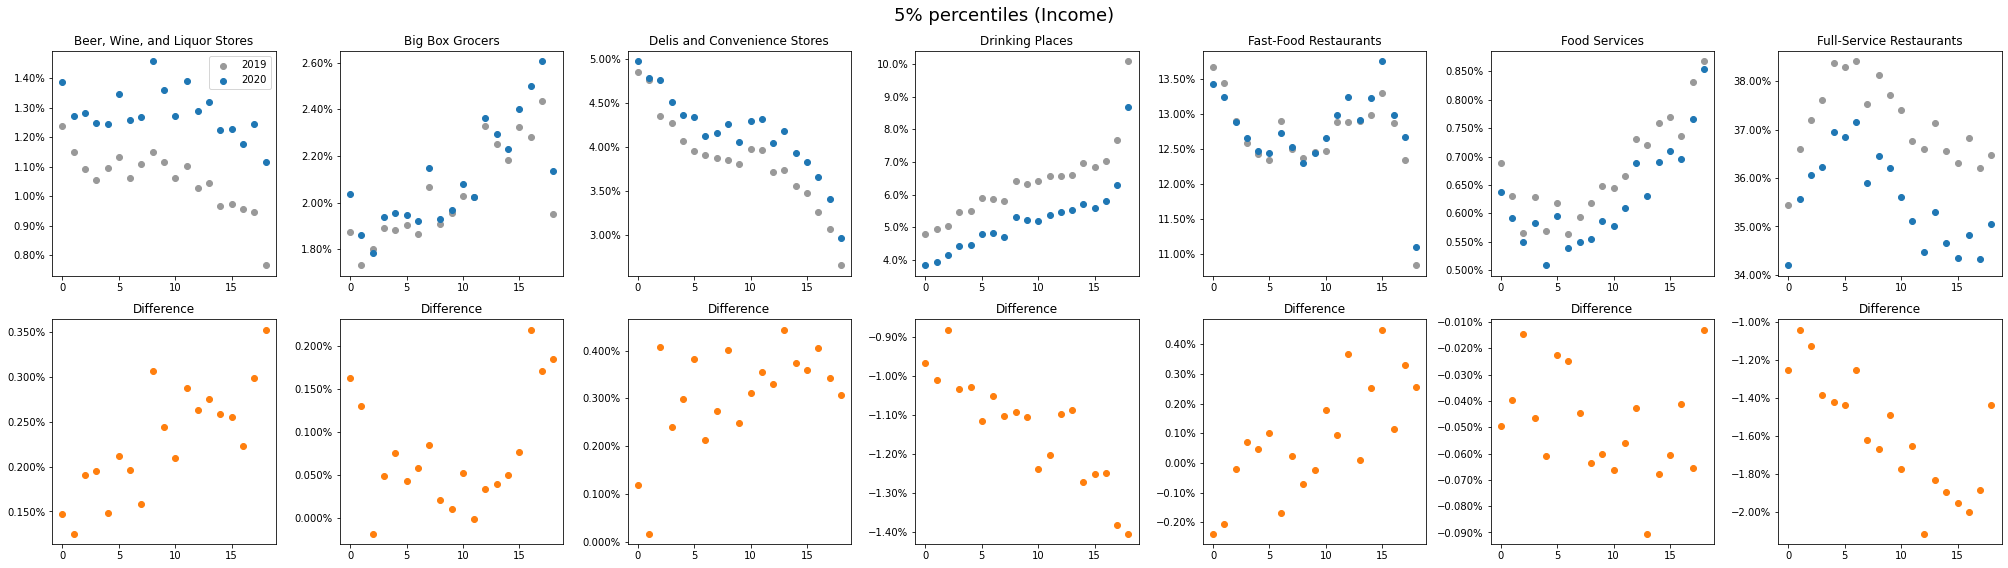

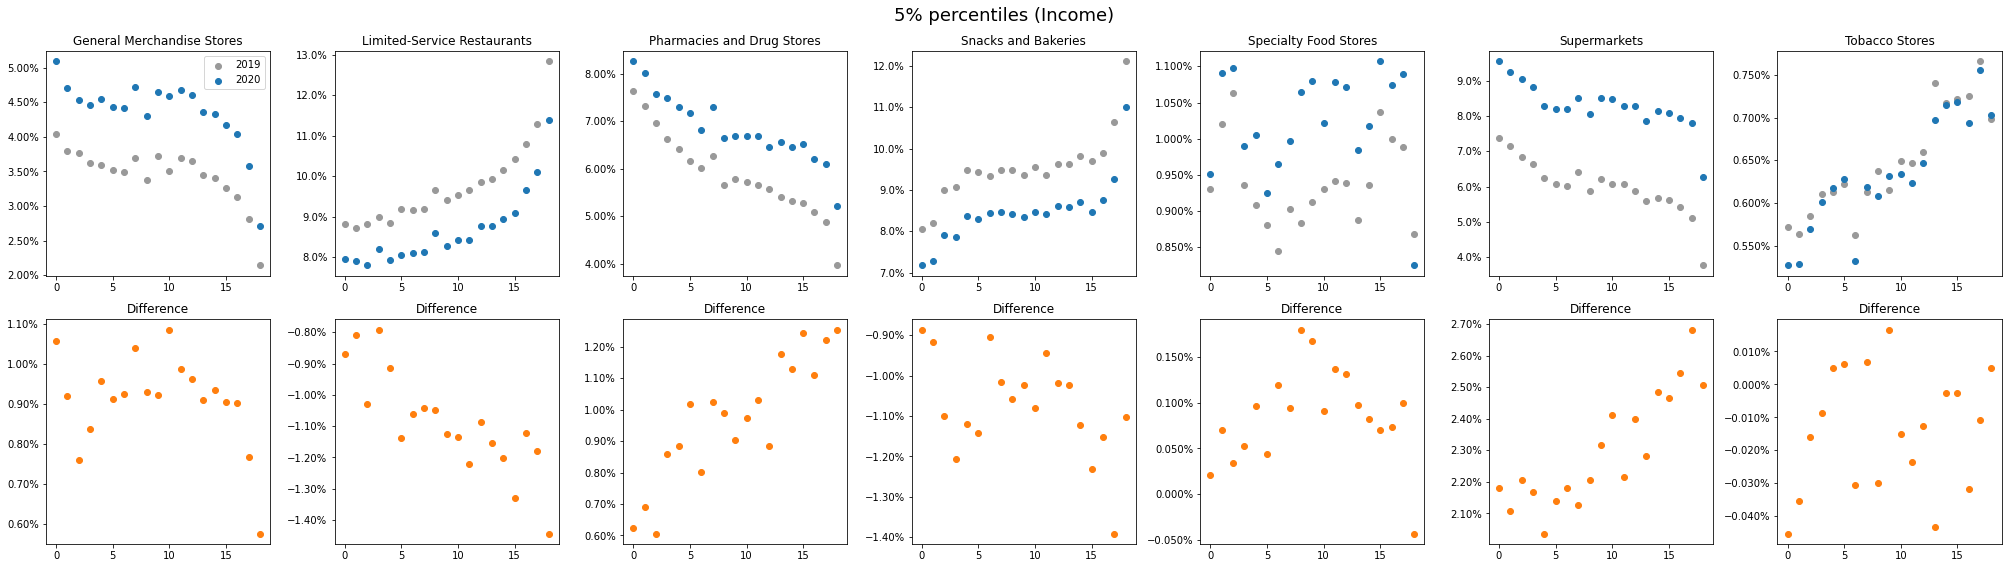

In [409]:
pdf_2020 = pct_percent_2020_mean_df
pdf_2019 = pct_percent_2019_mean_df
plot_scatter(pdf_2019, pdf_2020, pdf_2020.columns[:7])
plot_scatter(pdf_2019, pdf_2020, pdf_2020.columns[7:])

In [410]:
poi_hc_df = poi_df.copy()

unhealthy_food = [
    'Delis and Convenience Stores',
    'Fast-Food Restaurants',
]

unhealthy_substances = [
    'Beer, Wine, and Liquor Stores',
    'Drinking Places',
    'Tobacco Stores',
]

healthy_food = [
    'Supermarkets',
]

other = [
    'Big Box Grocers',
    'Food Services',
    'Full-Service Restaurants',
    'General Merchandise Stores',
    'Limited-Service Restaurants',
    'Pharmacies and Drug Stores',
    'Snacks and Bakeries',
    'Specialty Food Stores',
]

poi_hc_df.loc[poi_hc_df['category'].isin(unhealthy_food), 'category'] = 'Less Healthy Food'
poi_hc_df.loc[poi_hc_df['category'].isin(unhealthy_substances), 'category'] = 'Less Healthy Substances'
poi_hc_df.loc[poi_hc_df['category'].isin(healthy_food), 'category'] = 'More Healthy Food'
poi_hc_df.loc[poi_hc_df['category'].isin(other), 'category'] = 'Other'

In [411]:
hc_percent_df

category                           Less Healthy Food  Less Healthy Substances  \
date_range_start          cluster                                               
2019-01-07 00:00:00-05:00 0                      NaN                      NaN   
                          1                      NaN                      NaN   
                          2                      NaN                      NaN   
                          3                      NaN                      NaN   
                          4                      NaN                      NaN   
...                                              ...                      ...   
2020-12-28 00:00:00-05:00 15                     NaN                      NaN   
                          16                     NaN                      NaN   
                          17                     NaN                      NaN   
                          18                     NaN                      NaN   
                          19                     NaN                      NaN   

category                           More Healthy Food  Other  
date_range_start          cluster                            
2019-01-07 00:00:00-05:00 0                      NaN    NaN  
                          1                      NaN    NaN  
                          2                      NaN    NaN  
                          3                      NaN    NaN  
                          4                      NaN    NaN  
...                                              ...    ...  
2020-12-28 00:00:00-05:00 15                     NaN    NaN  
                          16                     NaN    NaN  
                          17                     NaN    NaN  
                          18                     NaN    NaN  
                          19                     NaN    NaN  

[2040 rows x 4 columns]

In [412]:
cbg_hc_df = apply_percentiles_by_income(cbg_df)
cbg_hc_df = cbg_hc_df[['cbg', 'cluster']]
hc_cluster_df = home_weekly_df.merge(cbg_hc_df, on=['cbg'], how='inner')
hc_total_df = get_total_df(hc_cluster_df)
hc_weekly_df = get_weekly_df(hc_cluster_df, hc_total_df, poi_df=poi_hc_df)
hc_percent_df = get_percent_df(hc_weekly_df)

[21441.0,
 30140.0,
 36541.5,
 41786.0,
 46599.0,
 51250.0,
 55306.5,
 59615.0,
 63725.5,
 68164.0,
 72500.0,
 76726.0,
 81686.0,
 86897.0,
 93750.0,
 101694.0,
 111272.5,
 128646.0,
 158452.0,
 250001.0]

,date_range_start,cluster,total_estimated_visitor_count
0,2019-01-07 00:00:00-05:00,0,134127.130010
1,2019-01-07 00:00:00-05:00,1,137427.876920
2,2019-01-07 00:00:00-05:00,2,136954.220221


2040


,date_range_start,category,cluster,estimated_visitor_count,total_estimated_visitor_count,percent
0,2019-01-07 00:00:00-05:00,Less Healthy Food,0,25078.270664,134127.130010,0.186974
4,2019-01-07 00:00:00-05:00,Less Healthy Food,1,25105.972535,137427.876920,0.182685
8,2019-01-07 00:00:00-05:00,Less Healthy Food,2,23283.276802,136954.220221,0.170008


8160


category                           Less Healthy Food  Less Healthy Substances  \
date_range_start          cluster                                               
2019-01-07 00:00:00-05:00 0                      NaN                      NaN   
                          1                      NaN                      NaN   
                          2                      NaN                      NaN   

category                           More Healthy Food  Other  
date_range_start          cluster                            
2019-01-07 00:00:00-05:00 0                      NaN    NaN  
                          1                      NaN    NaN  
                          2                      NaN    NaN

2040


In [413]:
hc_percent_2019_df = hc_percent_df.reset_index()
hc_percent_2019_df = hc_percent_2019_df[hc_percent_2019_df['date_range_start'].dt.year == 2019]
hc_percent_2019_df = hc_percent_2019_df.set_index(['date_range_start'])
hc_percent_2019_mean_df = hc_percent_2019_df.groupby(by=['cluster']).mean()
hc_percent_2020_df = hc_percent_df.reset_index()
hc_percent_2020_df = hc_percent_2020_df[hc_percent_2020_df['date_range_start'].dt.year == 2020]
hc_percent_2020_df = hc_percent_2020_df.set_index(['date_range_start'])
hc_percent_2020_mean_df = hc_percent_2020_df.groupby(by=['cluster']).mean()

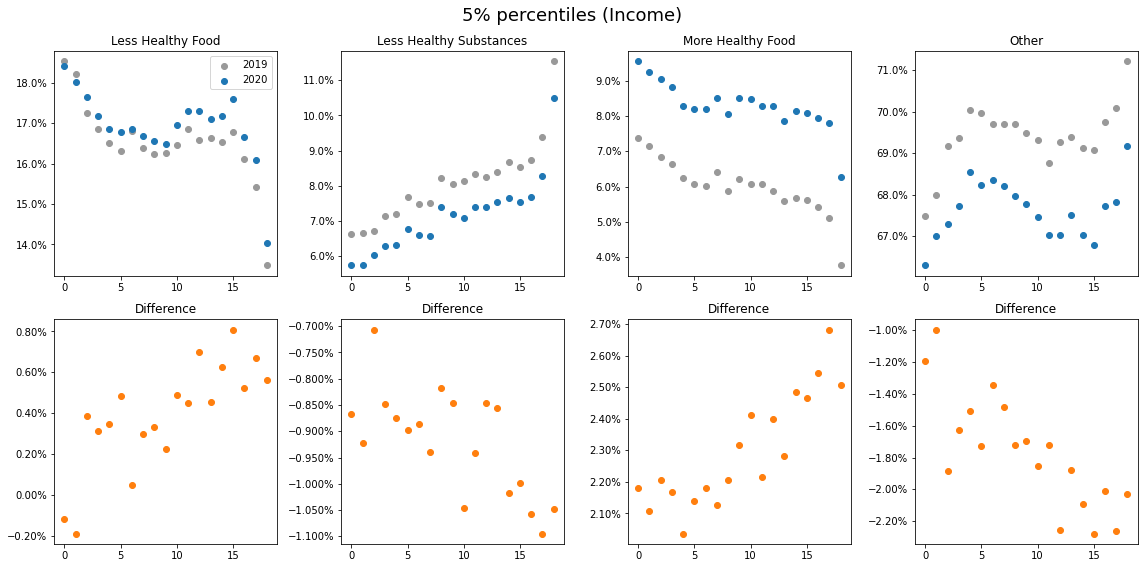

In [414]:
hc_df_2020 = hc_percent_2020_mean_df
hc_df_2019 = hc_percent_2019_mean_df
plot_scatter(hc_df_2019, hc_df_2020, hc_df_2020.columns)

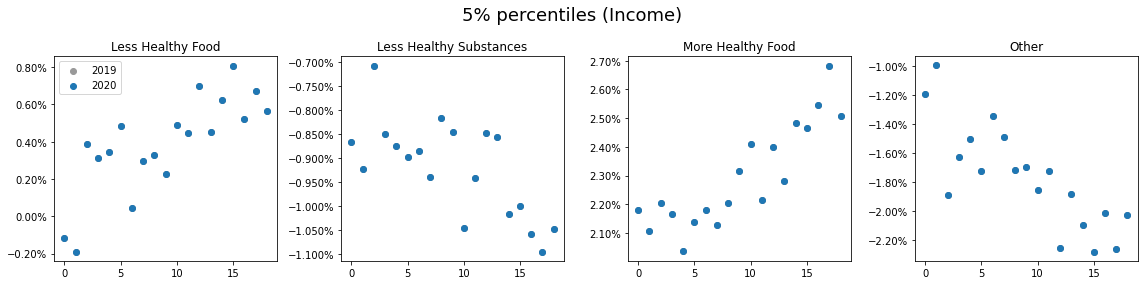